In [1]:
# imports 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)

#### Prepare

In [2]:
data_dir = ''

In [4]:
# load data
lyrics = pd.read_csv(data_dir + 'clean_lyrics_df.csv')
artist = pd.read_csv(data_dir + 'artists-data.csv')

lyrics['ALink'] = lyrics['ALink'].apply(lambda x: f'/{x.replace(" ","-")}/')

df = lyrics.merge(artist, left_on='ALink', right_on='Link')
df.drop(df[df['language']!='en'].index, inplace=True)
df.drop(['ALink','SLink','Link','language'], axis=1, inplace=True)
df.rename(columns={'SName': 'Title'}, inplace=True)
df.head()

,Title,Lyric,Artist,Genres,Songs,Popularity
0,In da Club,"go, go, go, go\ngo, go, go shawty\nit's your b...",50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
1,21 Questions,new york city!\nyou are now rapping...with 50 ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
2,P.I.M.P.,i don't know what you heard about me\nbut a b*...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
3,Many Men (Wish Death),man we gotta go get something to eat man\ni'm ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
4,Candy Shop,yeah...\nuh huh\nso seductive\ni'll take you t...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7


In [5]:
# Normalize popularity
df['PopNorm'] = (df['Popularity'] - df['Popularity'].min()) / (df['Popularity'].max() - df['Popularity'].min())
df['PopNorm'].describe()

count    13947.000000
mean         0.112686
std          0.198113
min          0.000000
25%          0.011314
50%          0.028721
75%          0.122715
max          1.000000
Name: PopNorm, dtype: float64

Convert 'Genres' to One-Hot encoding

In [6]:
vectorizer = CountVectorizer()

vectorizer.fit(df['Genres'].replace(';',''))
print('Vocabulary:', vectorizer.vocabulary_)

X = vectorizer.transform(df['Genres'])

Vocabulary: {'hip': 10, 'hop': 11, 'rap': 17, 'black': 0, 'music': 15, 'pop': 16, 'funk': 7, 'rockabilly': 19, 'romântico': 20, 'rock': 18, 'folk': 6, 'country': 3, 'blues': 1, 'dance': 4, 'soul': 21, 'disco': 5, 'hard': 8, 'heavy': 9, 'metal': 14, 'indie': 12, 'jazz': 13, 'clássico': 2, 'surf': 22}


Clustering Genre Sets

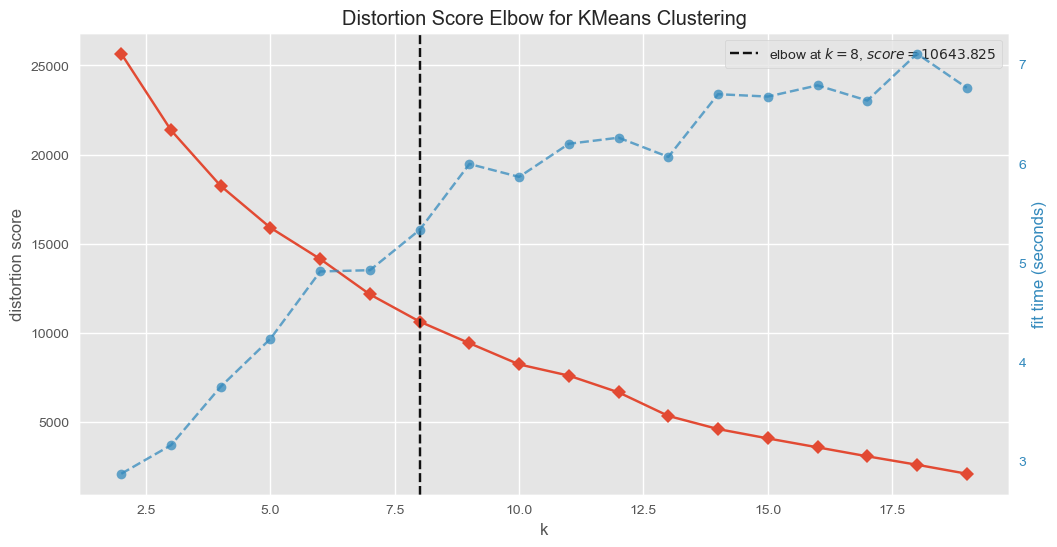

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
# Elbow score
import warnings
warnings.filterwarnings("ignore")

kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,20))
visualizer.fit(X)
visualizer.show()

In [8]:
kmeans.n_clusters = visualizer.elbow_value_
kmeans.fit(X)

df['genre_cluster'] = kmeans.labels_

In [9]:
# Cluster distribution
df.groupby('genre_cluster')['genre_cluster'].count().sort_values(ascending=False)

genre_cluster
1    4220
3    2008
2    1967
4    1590
7    1242
0    1126
5    1104
6     690
Name: genre_cluster, dtype: int64

Clustering Lyrics

In [10]:
vectorizer = TfidfVectorizer(max_df=0.7)

vectorizer.fit(df['Lyric'])
V = vectorizer.vocabulary_
print('Vocabulary:', dict(zip(list(V.keys())[:20], list(V.values())[:20])))

X = vectorizer.transform(df['Lyric'])

Vocabulary: {'go': 17504, 'shawty': 36539, 'your': 46996, 'birthday': 4234, 'we': 45315, 'gon': 17605, 'party': 29816, 'like': 23947, 'sip': 37284, 'bacardi': 2898, 'yo': 46910, 'know': 22925, 'don': 12281, 'give': 17319, 'not': 28247, 'can': 6440, 'find': 15344, 'club': 8252, 'bottle': 5106, 'full': 16548}


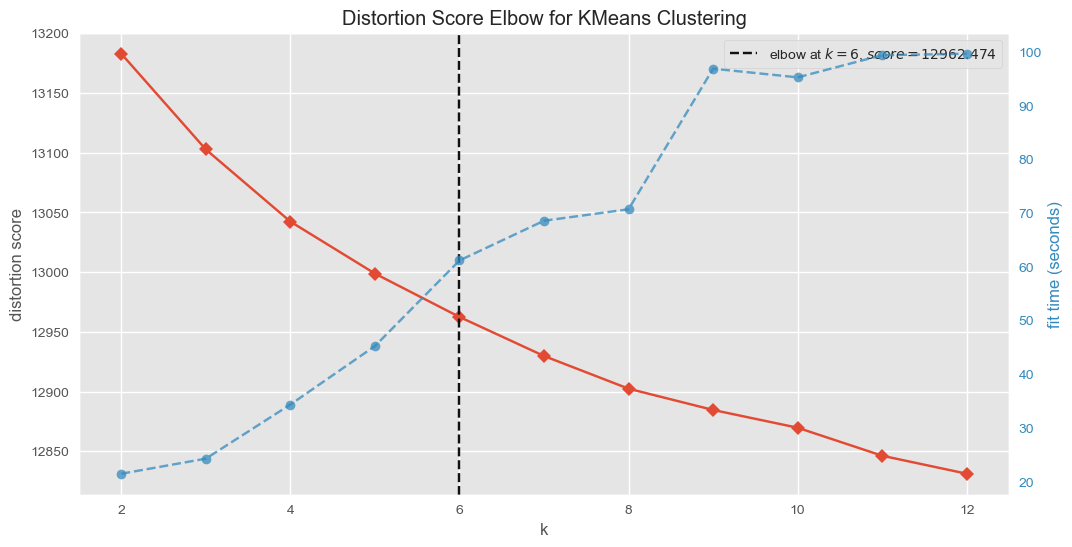

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Elbow score
import warnings
warnings.filterwarnings("ignore")

kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,13))
visualizer.fit(X)
visualizer.show()

In [22]:
kmeans.n_clusters = visualizer.elbow_value_
kmeans.fit(X)

df['lyric_cluster'] = kmeans.labels_

For n_clusters = 8, the average silhouette score is: 0.0034013914301603988
For n_clusters = 9, the average silhouette score is: 0.003126895634346522
For n_clusters = 10, the average silhouette score is: 0.0038668025472982713
For n_clusters = 11, the average silhouette score is: 0.004213388739214114
For n_clusters = 12, the average silhouette score is: 0.004680283496478888
For n_clusters = 13, the average silhouette score is: 0.004559895865332123
For n_clusters = 14, the average silhouette score is: 0.004490747104840479
For n_clusters = 15, the average silhouette score is: 0.0036422900431144285


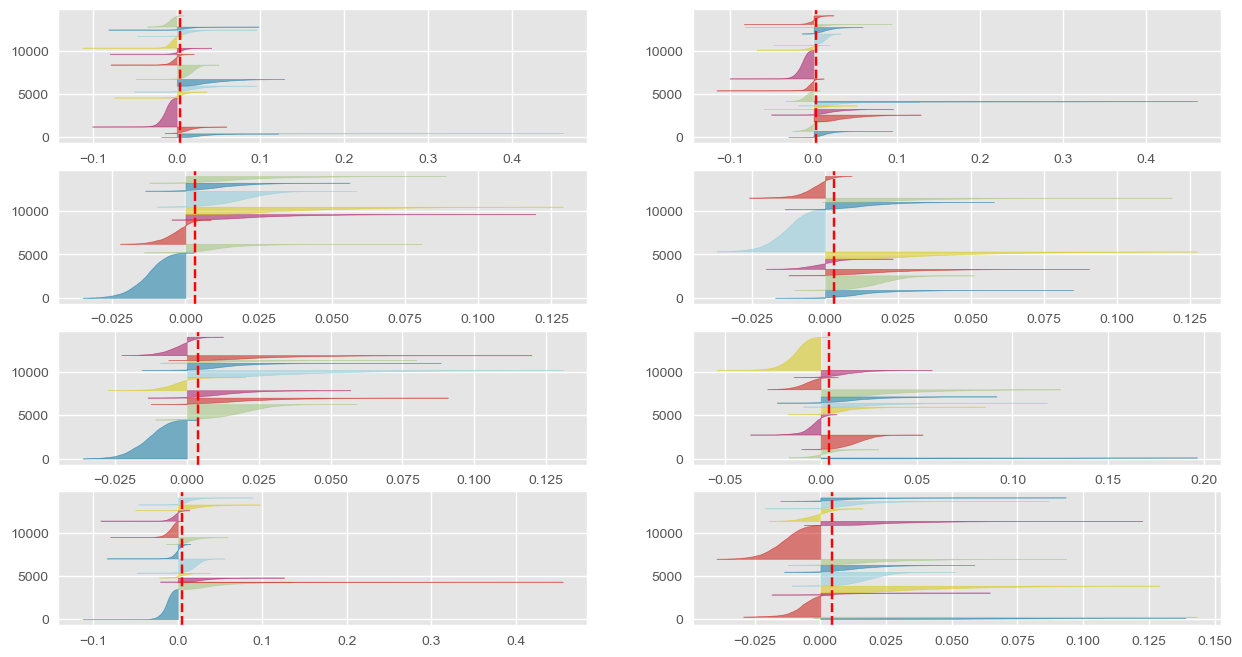

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(8,16):
    '''
    Create KMeans instances for different number of clusters
    '''
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer_s = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-7][mod])
    visualizer_s.fit(X)
    print(f'For n_clusters = {visualizer_s.n_clusters_}, the average silhouette score is: {visualizer_s.silhouette_score_}')

    # adapted from code in Medium article by Anmol Tomar
    # https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

Text(0, 0.5, 'Number of Songs')

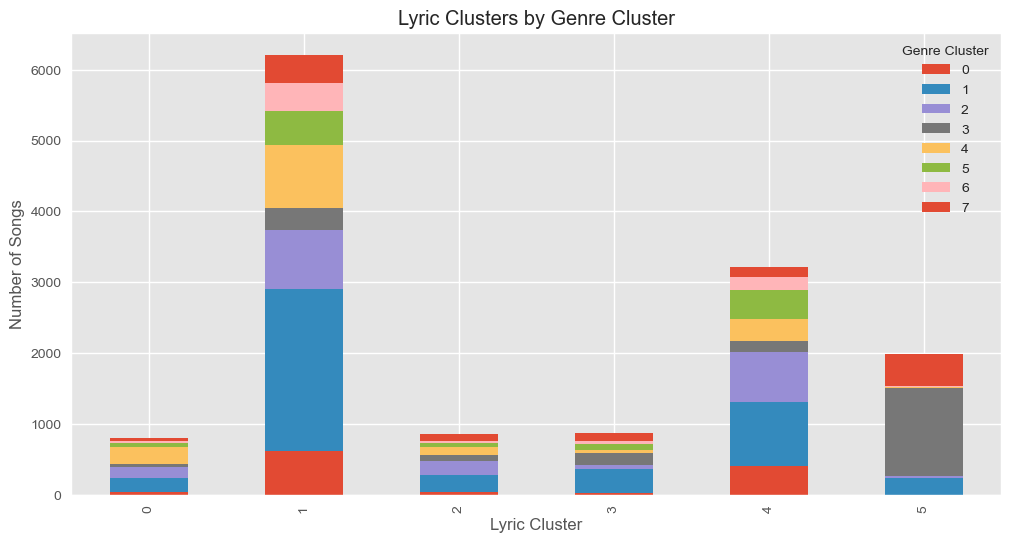

In [24]:
group = df.groupby(['lyric_cluster','genre_cluster'])['Title'].count().reset_index()
pivot = pd.pivot_table(data=group, index=['lyric_cluster'], columns=['genre_cluster'], values='Title')
pivot.plot.bar(stacked=True, title='Lyric Clusters by Genre Cluster')
plt.legend(title='Genre Cluster')
plt.xlabel('Lyric Cluster')
plt.ylabel('Number of Songs')

In [43]:
tsne = TSNEVisualizer()
tsne.fit(X, df['genre_cluster'], title='TSNE')
tsne.title = 'TSNE Projection of Lyric Vectors by Genre Cluster'
tsne.show()